### Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys, yaml
sys.path.append('../')
sys.path.append('../../')
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations,events_dev as events,culture as c

import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [2]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1, 'water_level': 20}

In [3]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

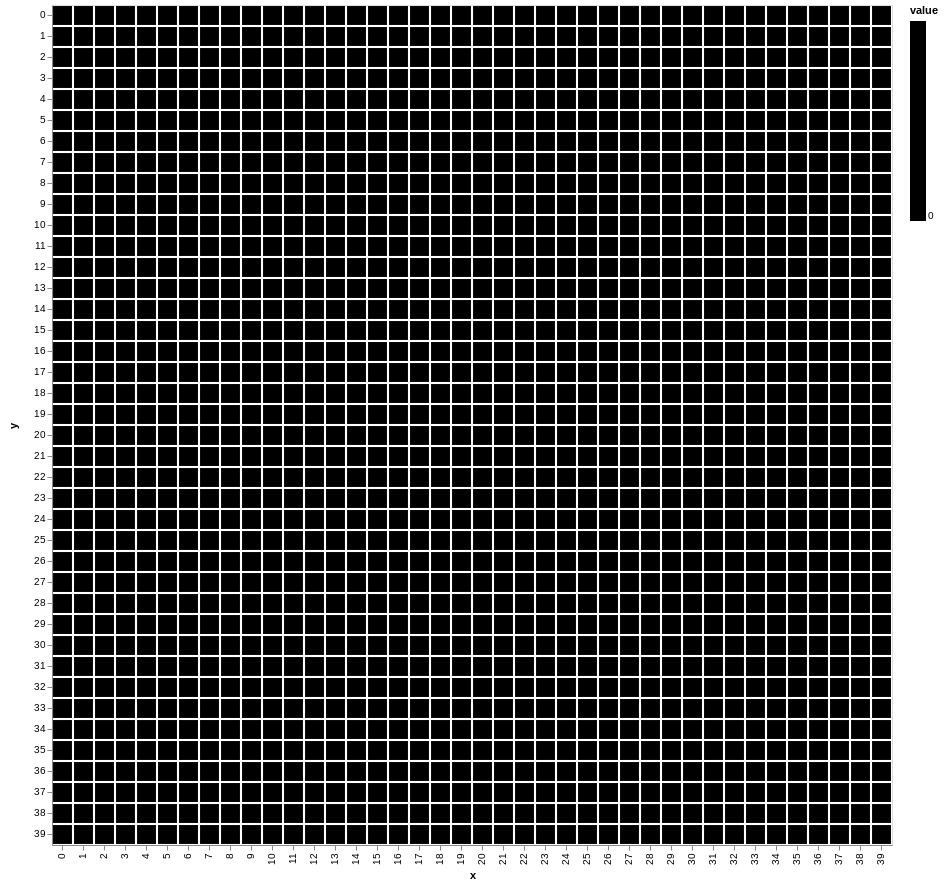

In [4]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated procedurally. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

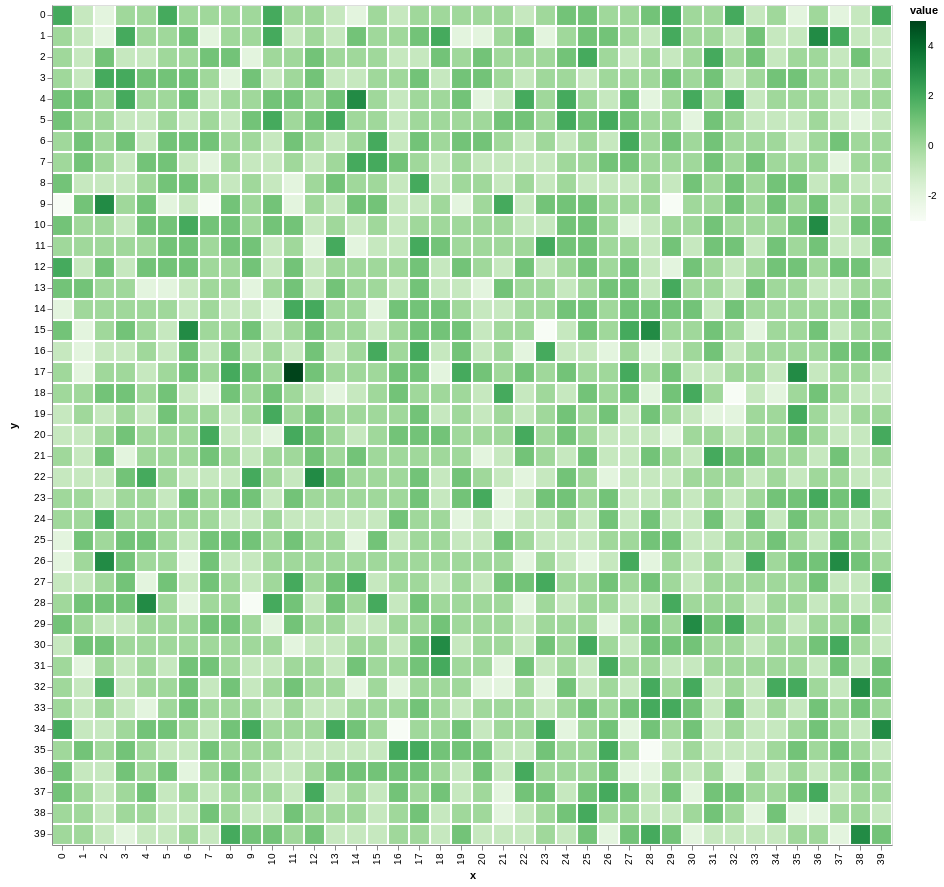

In [5]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [6]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symmetrically.

In [7]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [27  2]


,-2,-1,0,1,2,3,4,5,6
23,1,1,1,1,1,1,1,1,1
24,1,2,2,2,2,2,2,2,1
25,1,2,3,3,3,3,3,2,1
26,1,2,3,4,4,4,3,2,1
27,1,2,3,4,5,4,3,2,1
28,1,2,3,4,4,4,3,2,1
29,1,2,3,3,3,3,3,2,1
30,1,2,2,2,2,2,2,2,1
31,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

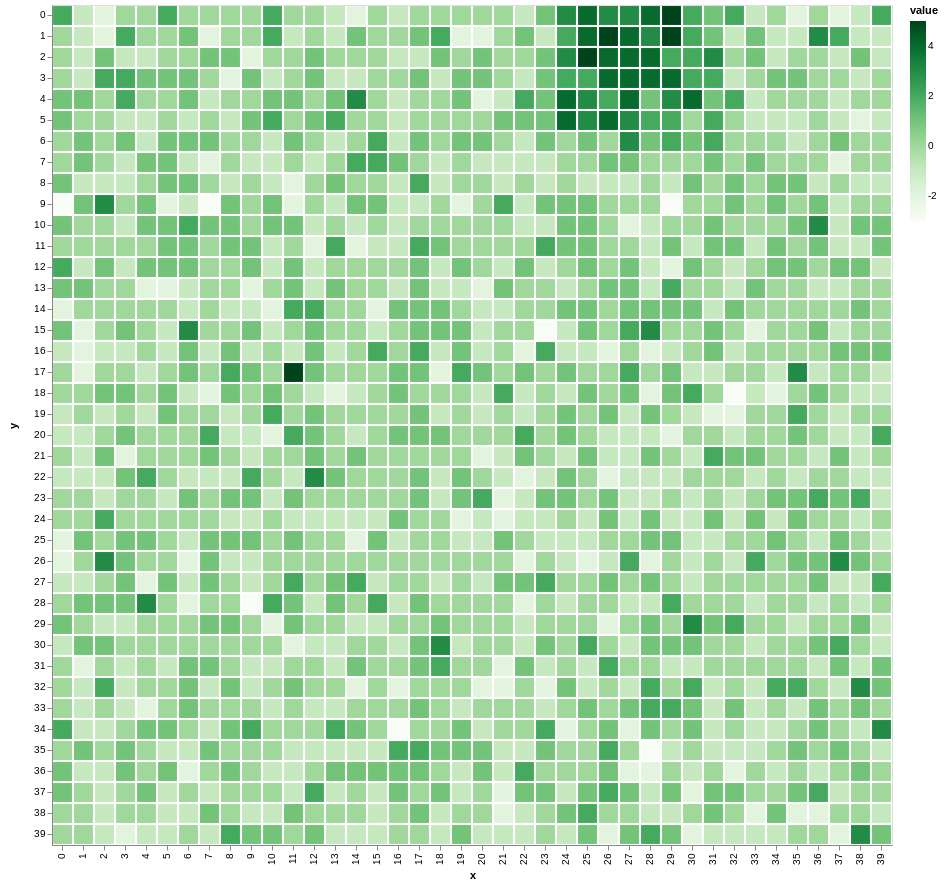

In [8]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board I'll need to create a brownian motion function to drop a mountain and then move. 

In [9]:
world.brownian_land()

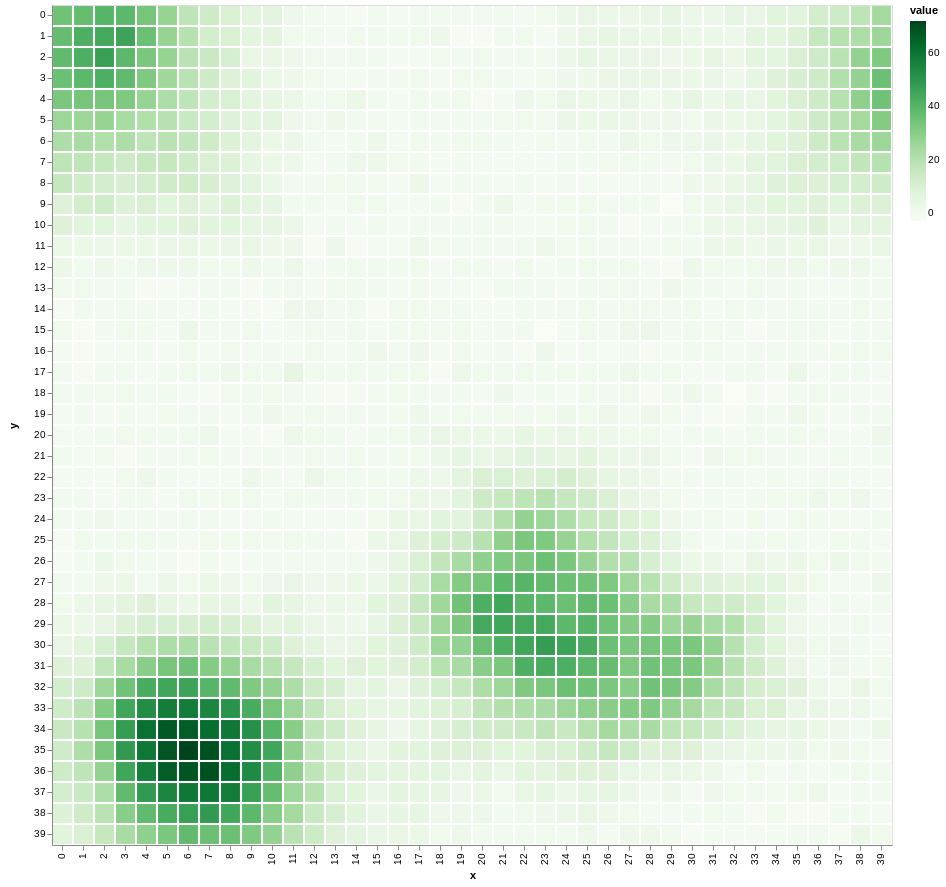

In [10]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `height == 0` then you can assume that lower terrain is _under water_

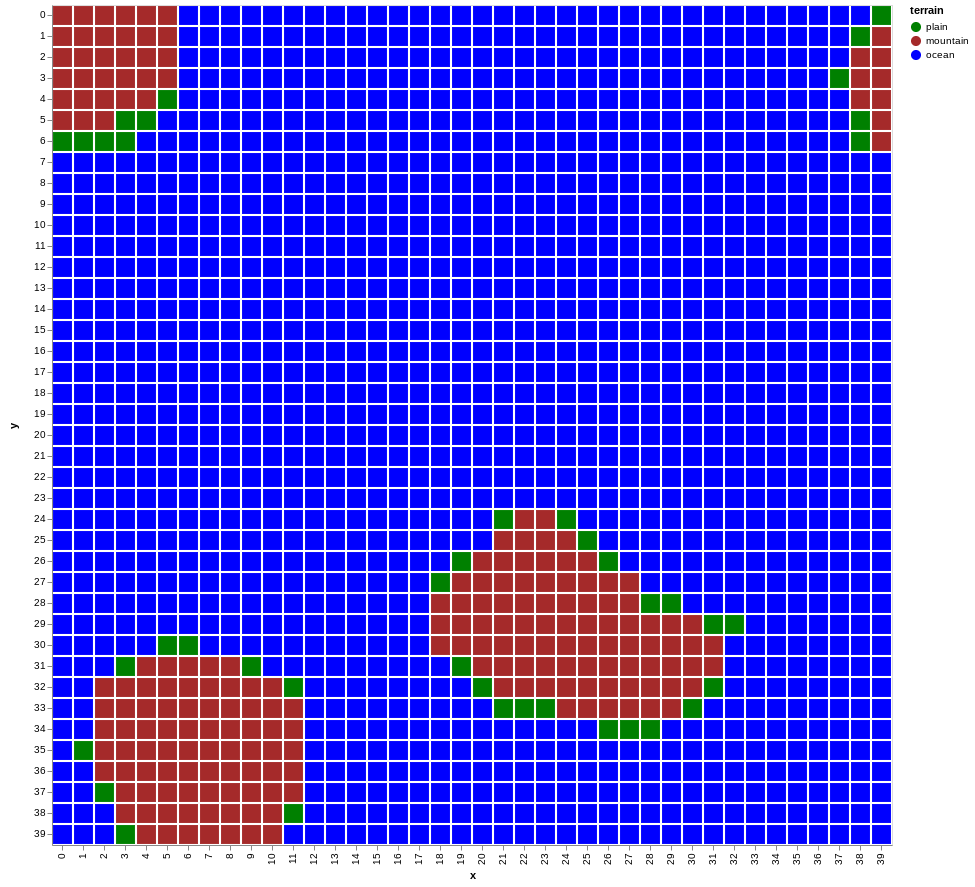

In [11]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forests. Dry areas become deserts. 

In [12]:
world.brownian_rainfall()

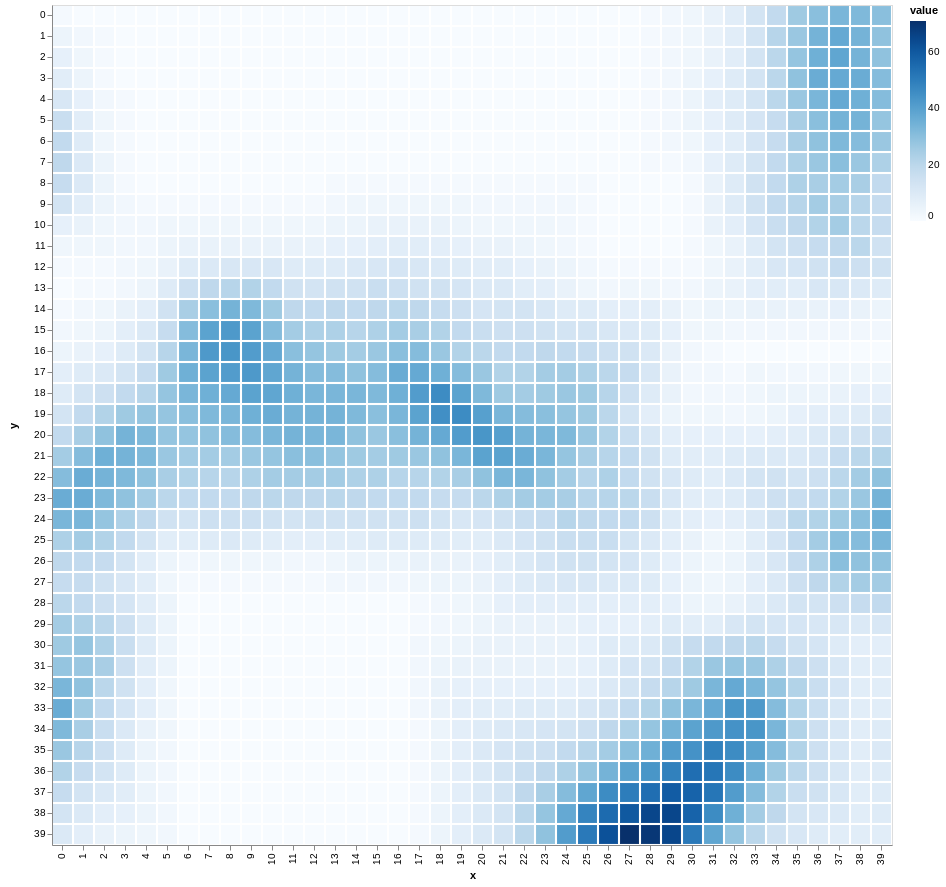

In [13]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [14]:
world.build_df_features()

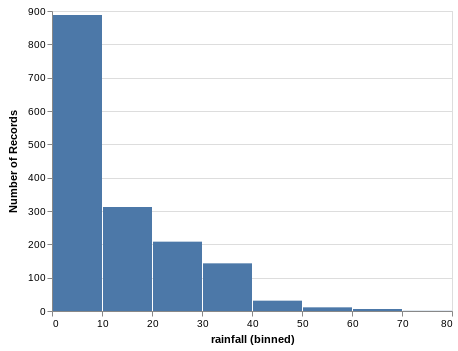

In [15]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

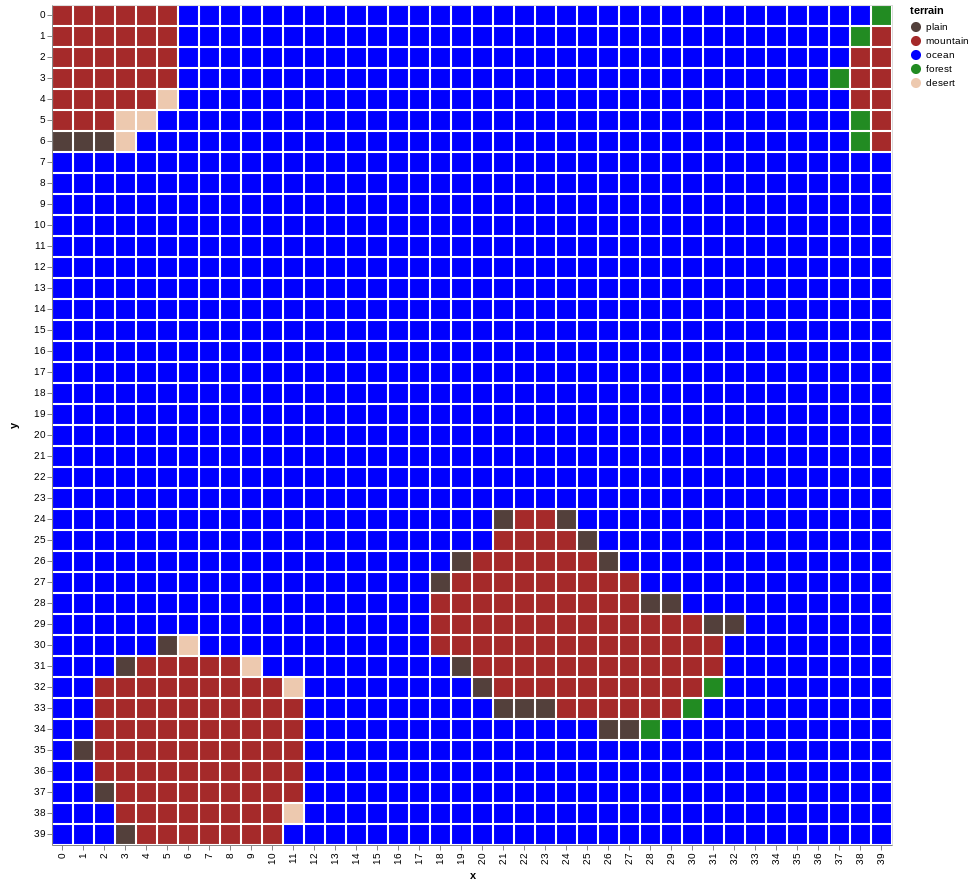

In [16]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the Mortals

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes and forests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 


In [17]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [18]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [19]:
people.Person(world.culture,location=world.get_random_chord())

Grolnard the commoner

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [20]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Tearwish: population: 1 location: [27,39] founded 1

In [21]:
new_town.speaker

Shotendadle the Speaker of Tearwish

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [22]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Oakmain: population: 5 location: [28,32] founded 0',
  [Quikillol the Speaker of Oakmain,
   Irabranad the commoner,
   Chakleh the commoner,
   Thalnosh the commoner,
   Fafaddett the commoner]),
 ('town of Buckmain: population: 3 location: [20,27] founded 0',
  [Draharkus the Speaker of Buckmain,
   Stukillad the commoner,
   Fazennif the commoner]),
 ('town of Buckloch: population: 5 location: [31,30] founded 1',
  [Orklipech the Speaker of Buckloch,
   Quawace the commoner,
   Debranac the commoner,
   Kishich the commoner,
   Mallunder the commoner]),
 ('town of Godrest: population: 1 location: [18,30] founded 1',
  [Zhowildep the Speaker of Godrest]),
 ('town of Leafcrest: population: 4 location: [5,1] founded 1',
  [Seklipik the Speaker of Leafcrest,
   Urngam the commoner,
   Frasassow the commoner,
   Elipartace the commoner]),
 ('town of Rockblade: population: 1 location: [7,37] founded 2',
  [Algordec the Speaker of Rockblade]),
 ('town of Ragebridge: population: 

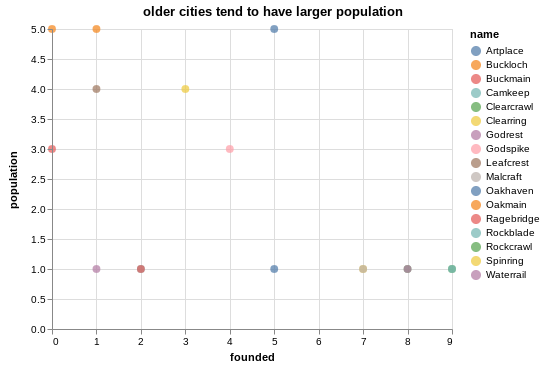

In [23]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

## Adding the towns to the map: 

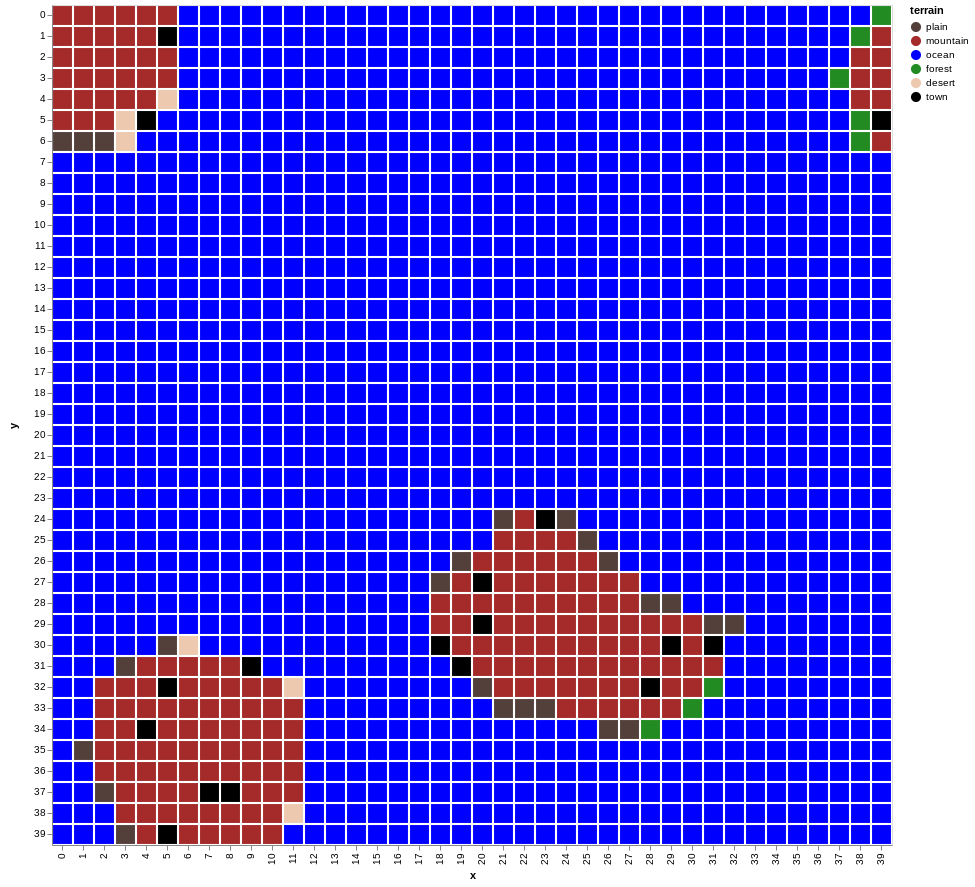

In [24]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

In [25]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
5:1,1,0.0,5,5:1,27.0,town,Leafcrest
4:5,5,0.0,4,4:5,21.0,town,Waterrail
39:5,5,28.0,39,39:5,31.0,town,Oakhaven
23:24,24,17.0,23,23:24,26.0,town,Clearring
20:27,27,5.0,20,20:27,34.0,town,Buckmain
20:29,29,4.0,20,20:29,44.0,town,Artplace
18:30,30,3.0,18,18:30,26.0,town,Godrest
29:30,30,14.0,29,29:30,33.0,town,Godspike
31:30,30,18.0,31,31:30,28.0,town,Buckloch


# Nations

In [26]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Rockkeep',
 1: 'Ratbridge',
 2: 'Warhenge',
 3: 'Servantsloch',
 4: 'Ragejaw',
 5: 'Hardhenge',
 6: 'Purerest',
 7: 'Earthspring'}

Standard Scikit-Learn stuff

In [27]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,1.0,0,0:0,35.0,mountain,NaN,3.0,Servantsloch
1:0,0,0.0,1,1:0,37.0,mountain,NaN,3.0,Servantsloch
2:0,0,0.0,2,2:0,40.0,mountain,NaN,3.0,Servantsloch
3:0,0,0.0,3,3:0,39.0,mountain,NaN,3.0,Servantsloch
4:0,0,0.0,4,4:0,34.0,mountain,NaN,3.0,Servantsloch
5:0,0,0.0,5,5:0,27.0,mountain,NaN,3.0,Servantsloch
6:0,0,0.0,6,6:0,18.0,ocean,NaN,NaN,NaN
7:0,0,0.0,7,7:0,14.0,ocean,NaN,NaN,NaN
8:0,0,0.0,8,8:0,10.0,ocean,NaN,NaN,NaN


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [29]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Buckmain is loyal to the nation of Ragejaw
{'nation': 'Ragejaw', 'national fealty': 1}


In [30]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Oakmain: population: 5 location: [28,32] founded 0,
 capitol of Buckmain: population: 3 location: [20,27] founded 0,
 town of Buckloch: population: 5 location: [31,30] founded 1,
 town of Godrest: population: 1 location: [18,30] founded 1,
 capitol of Leafcrest: population: 4 location: [5,1] founded 1,
 capitol of Rockblade: population: 1 location: [7,37] founded 2,
 town of Ragebridge: population: 1 location: [5,39] founded 2,
 capitol of Clearring: population: 4 location: [23,24] founded 3,
 town of Godspike: population: 3 location: [29,30] founded 4,
 capitol of Oakhaven: population: 5 location: [39,5] founded 5,
 town of Artplace: population: 1 location: [20,29] founded 5,
 town of Spinring: population: 1 location: [8,37] founded 7,
 town of Malcraft: population: 1 location: [19,31] founded 7,
 capitol of Clearcrawl: population: 1 location: [4,34] founded 8,
 town of Waterrail: population: 1 location: [4,5] founded 8,
 town of Rockcrawl: population: 1 location: [5,32] f

In [31]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Rockkeep,
 Nation of Ratbridge,
 Nation of Warhenge,
 Nation of Servantsloch,
 Nation of Ragejaw,
 Nation of Hardhenge,
 Nation of Purerest,
 Nation of Earthspring]

In [32]:
world.nations[0].towns

[capitol of Oakhaven: population: 5 location: [39,5] founded 5]

In [33]:
world.nations[0].get_capitol().population

[Kispeb the Speaker of Oakhaven,
 Pexand the commoner,
 Tragsend the commoner,
 Thodellove the commoner,
 Poffottle the commoner,
 Erireshim the Ruler of the nation of Rockkeep]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nation's capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [34]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Kispeb',
 'role': 'Speaker of Oakhaven',
 'loyalty': 0.5,
 'temperment': 0.37,
 'attributes': ['alive']}

In [35]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
5:39,39,2.0,5,5:39,33.0,town,Ragebridge,7.0,Earthspring
7:37,37,0.0,7,7:37,59.0,town,Rockblade,7.0,Earthspring
8:37,37,0.0,8,8:37,58.0,town,Spinring,7.0,Earthspring
23:24,24,17.0,23,23:24,26.0,town,Clearring,5.0,Hardhenge
9:31,31,0.0,9,9:31,23.0,town,Camkeep,6.0,Purerest
20:27,27,5.0,20,20:27,34.0,town,Buckmain,4.0,Ragejaw
20:29,29,4.0,20,20:29,44.0,town,Artplace,4.0,Ragejaw
18:30,30,3.0,18,18:30,26.0,town,Godrest,4.0,Ragejaw
19:31,31,5.0,19,19:31,23.0,town,Malcraft,4.0,Ragejaw


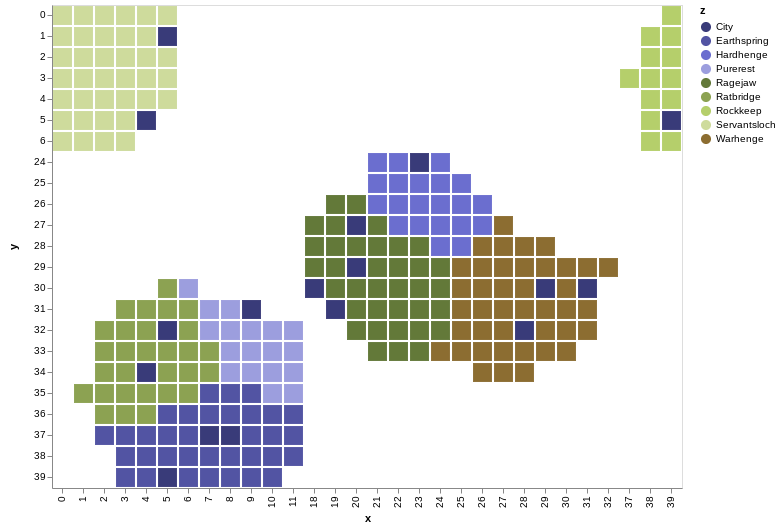

In [36]:
draw.drawboarders(world.df_features)

# The age of the Conflict

The terrain and all of the natural features are formed in the first age. Cities and nations in the second. In the third age chaos will shift the natural order and cause the tension that creates the objectives of the game. 


In [37]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Buckmain is loyal to the nation of Ragejaw
{'nation': 'Ragejaw', 'national fealty': 1}


People have loyalty to thier nations, as well as towns. Nations have a loyalty to each other. Towns have speakers, who represent the town. Nations have rulers. 

In [38]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Tihorkundle the Ruler of the nation of Ratbridge  has a temperment of  0.96
Nenkef the Speaker of Clearcrawl  has a loyalty of  0.5


In [39]:
world.get_filtered_chord(t=['plain','mountain','forrest'],n=example_nation.name,r='key')

'5:13'

In [40]:
example_nation.towns

[capitol of Clearcrawl: population: 1 location: [4,34] founded 8,
 town of Rockcrawl: population: 1 location: [5,32] founded 9]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [41]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


In [42]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [43]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [44]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Rockkeep did something -0.25 to [Nation of Ratbridge, Nation of Warhenge]
Nation of Rockkeep 
 Earthspring:
  favor: 0.8
  stance: peace
Hardhenge:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Ratbridge:
  favor: 0.8
  stance: peace
Servantsloch:
  favor: 0.8
  stance: peace
Warhenge:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Ratbridge 
 Earthspring:
  favor: 0.8
  stance: peace
Hardhenge:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Rockkeep:
  favor: 0.55
  stance: tense
Servantsloch:
  favor: 0.8
  stance: peace
Warhenge:
  favor: 0.8
  stance: peace

Nation of Warhenge 
 Earthspring:
  favor: 0.8
  stance: peace
Hardhenge:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Ratbridge:
  favor:

[None, None]

### example 2: several nations does something that annother nation likes. 

In [45]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [46]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Warhenge, Nation of Servantsloch] did something 0.25 to Nation of Hardhenge
Nation of Warhenge 
 Earthspring:
  favor: 0.8
  stance: peace
Hardhenge:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Ratbridge:
  favor: 0.8
  stance: peace
Rockkeep:
  favor: 0.55
  stance: tense
Servantsloch:
  favor: 0.8
  stance: peace

Nation of Servantsloch 
 Earthspring:
  favor: 0.8
  stance: peace
Hardhenge:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Ratbridge:
  favor: 0.8
  stance: peace
Rockkeep:
  favor: 0.8
  stance: peace
Warhenge:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Hardhenge 
 Earthspring:
  favor: 0.8
  stance: peace
Purerest:
  favor: 0.8
  stance: peace
Ragejaw:
  favor: 0.8
  stance: peace
Ratbridge:
  favor: 0.8
  stance: peace
Rockkeep:
  fav

Events are thier own thing. They aren't `culture` or `landscape`. They happen at the beginning of the game and depending on `culture.chaos` happen when the character moves from area to area. 

In [47]:
e = events.Events(paths="notebooks")

 `culture.eons` determines how many years will pass with a possibility of an event happening. `culture.chaos` determines how likely an event is to occur.

In [48]:
[np.random.choice(np.random.choice(np.random.choice(world.nations).towns).population) for n in range(2)]

[Sakresh the Speaker of Waterrail, Shofaddus the Speaker of Malcraft]

In [50]:
world.nations[1].towns[1].population

[Sotoldec the Speaker of Rockcrawl]

In [51]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [52]:
#now to run through the eons and let fate happen
all_events = events.pass_through_time(world,e.events_df,nations)
all_events

['0: a noble from [Nation of Hardhenge] was married to a noble in [Nation of Servantsloch]',
 '1: a noble from [Nation of Hardhenge] was married to a noble in [Nation of Rockkeep]',
 '2: raiders from [Nation of Servantsloch], plundered [Nation of Servantsloch, Nation of Earthspring, Nation of Rockkeep]',
 '3: nothing happend during this period.',
 '4: a great temple was founded in the nation of [Nation of Warhenge]',
 '5: raiders from [Nation of Servantsloch], plundered [Nation of Ratbridge, Nation of Ragejaw, Nation of Purerest]',
 '6: raiders from [Nation of Earthspring], plundered [Nation of Ragejaw, Nation of Rockkeep, Nation of Hardhenge]',
 '7: nothing happend during this period.',
 '8: nothing happend during this period.',
 '9: raiders from [Nation of Earthspring], plundered [Nation of Rockkeep, Nation of Purerest, Nation of Warhenge]']

# Monsters and Enemies

In [53]:
world.culture.chaos

0.6

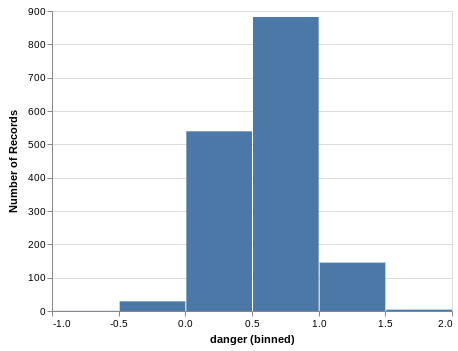

In [54]:
world = events.add_chaos_to_world(world)

alt.Chart(world.df_features).mark_bar().encode(
    alt.X("danger", bin=True),
    y='count()',
)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [55]:
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation,z,danger
key,,,,,,,,,,,
0:0,0,1.0,0,0:0,35.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.897
1:0,0,0.0,1,1:0,37.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.930
2:0,0,0.0,2,2:0,40.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.943
3:0,0,0.0,3,3:0,39.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.288
4:0,0,0.0,4,4:0,34.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.865
5:0,0,0.0,5,5:0,27.0,mountain,NaN,3.0,Servantsloch,Servantsloch,0.770
6:0,0,0.0,6,6:0,18.0,ocean,NaN,NaN,NaN,NaN,0.443
7:0,0,0.0,7,7:0,14.0,ocean,NaN,NaN,NaN,NaN,0.730
8:0,0,0.0,8,8:0,10.0,ocean,NaN,NaN,NaN,NaN,0.711


In [56]:
with open('world.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)